In [1]:
from torch import nn
from torch.nn import functional as F


class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()

        def resnet_block(input_channels, num_channels, num_residuals,
                         first_block=False):
            blk = []
            for i in range(num_residuals):
                if i == 0 and not first_block:
                    blk.append(Residual(input_channels, num_channels,
                                        use_1x1conv=True, strides=2))
                else:
                    blk.append(Residual(num_channels, num_channels))
            return blk

        self.net = nn.Sequential(
            nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                          nn.BatchNorm2d(64), nn.ReLU(),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
            nn.Sequential(*resnet_block(64, 64, 2, first_block=True)),
            nn.Sequential(*resnet_block(64, 128, 2)),
            nn.Sequential(*resnet_block(128, 256, 2)),
            nn.Sequential(*resnet_block(256, 512, 2)),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512, 100))

    def forward(self, x):
        x = self.net(x)
        return x

In [2]:
import torch.optim
import torchvision.transforms as transforms
import torchvision
from d2l import torch as d2l

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

batch_size = 128

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


def evaluate_accuracy_gpu(net, data_iter, loss, device=None):
    net.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            metric.add(d2l.accuracy(y_hat, y), y.numel(), l * y.numel())
    return metric[0] / metric[1], metric[2] / metric[1]


def train(net, train_iter, valid_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    train_timer, valid_timer, num_batches = d2l.Timer(), d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            train_timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_timer.start()
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            valid_timer.stop()
            animator.add(epoch + 1, (None, None, valid_acc))
    d2l.plt.show()

    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / train_timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    print(f'traing time {train_timer.sum():.3f} sec')
    print(f'traing time {valid_timer.sum():.3f} sec')

Files already downloaded and verified
Files already downloaded and verified


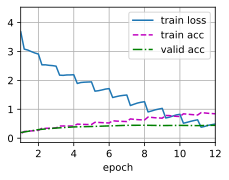

loss 0.491, train acc 0.844, valid acc 0.447
1608.3 examples/sec on cuda:0
traing time 373.063 sec
traing time 48.377 sec


In [3]:
device = torch.device("cuda")
net = ResNet()
lr, num_epochs = 0.003, 10
train(net, trainloader, validloader, num_epochs, lr, d2l.try_gpu())

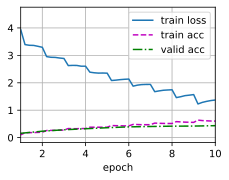

loss 1.371, train acc 0.602, valid acc 0.435
1628.8 examples/sec on cuda:0
traing time 306.972 sec
traing time 40.000 sec


In [4]:
device = torch.device("cuda")
net = ResNet()
lr, num_epochs = 0.003, 10
train(net, trainloader, validloader, num_epochs, lr, d2l.try_gpu())

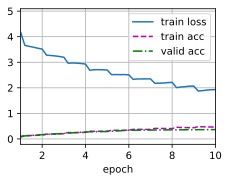

loss 1.932, train acc 0.466, valid acc 0.366
1615.4 examples/sec on cuda:0
traing time 309.523 sec
traing time 39.757 sec


In [7]:
device = torch.device("cuda")
net = ResNet()
lr, num_epochs = 0.008, 10
train(net, trainloader, validloader, num_epochs, lr, d2l.try_gpu())